# 猫狗大战

## 准备工作

下载数据，用kaggle的API：

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

In [2]:
# !kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

In [ ]:
# !unzip train
# !unzip test
# !rm train.zip
# !rm test.zip

现在文件夹结构如下：
```
\Dogs_vs_Cats
    \train  
    \test
```

导入用到的库：

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os, shutil
from tqdm import tqdm
import pickle

from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## 数据观察与预处理

先列出训练数据集`train`文件夹下的所有文件名。

In [4]:
data_dir = './{}/'
files = {x: os.listdir(data_dir.format(x)) for x in ['train', 'test']}

训练集中各种类的分布如何？

In [5]:
labels = [x.split('.')[0] for x in files['train']]
{i: labels.count(i) for i in set(labels)}

{'dog': 12500, 'cat': 12500}

各类别的分布是1:1，是均衡的。

### 随机抽取部分样本进行观察。

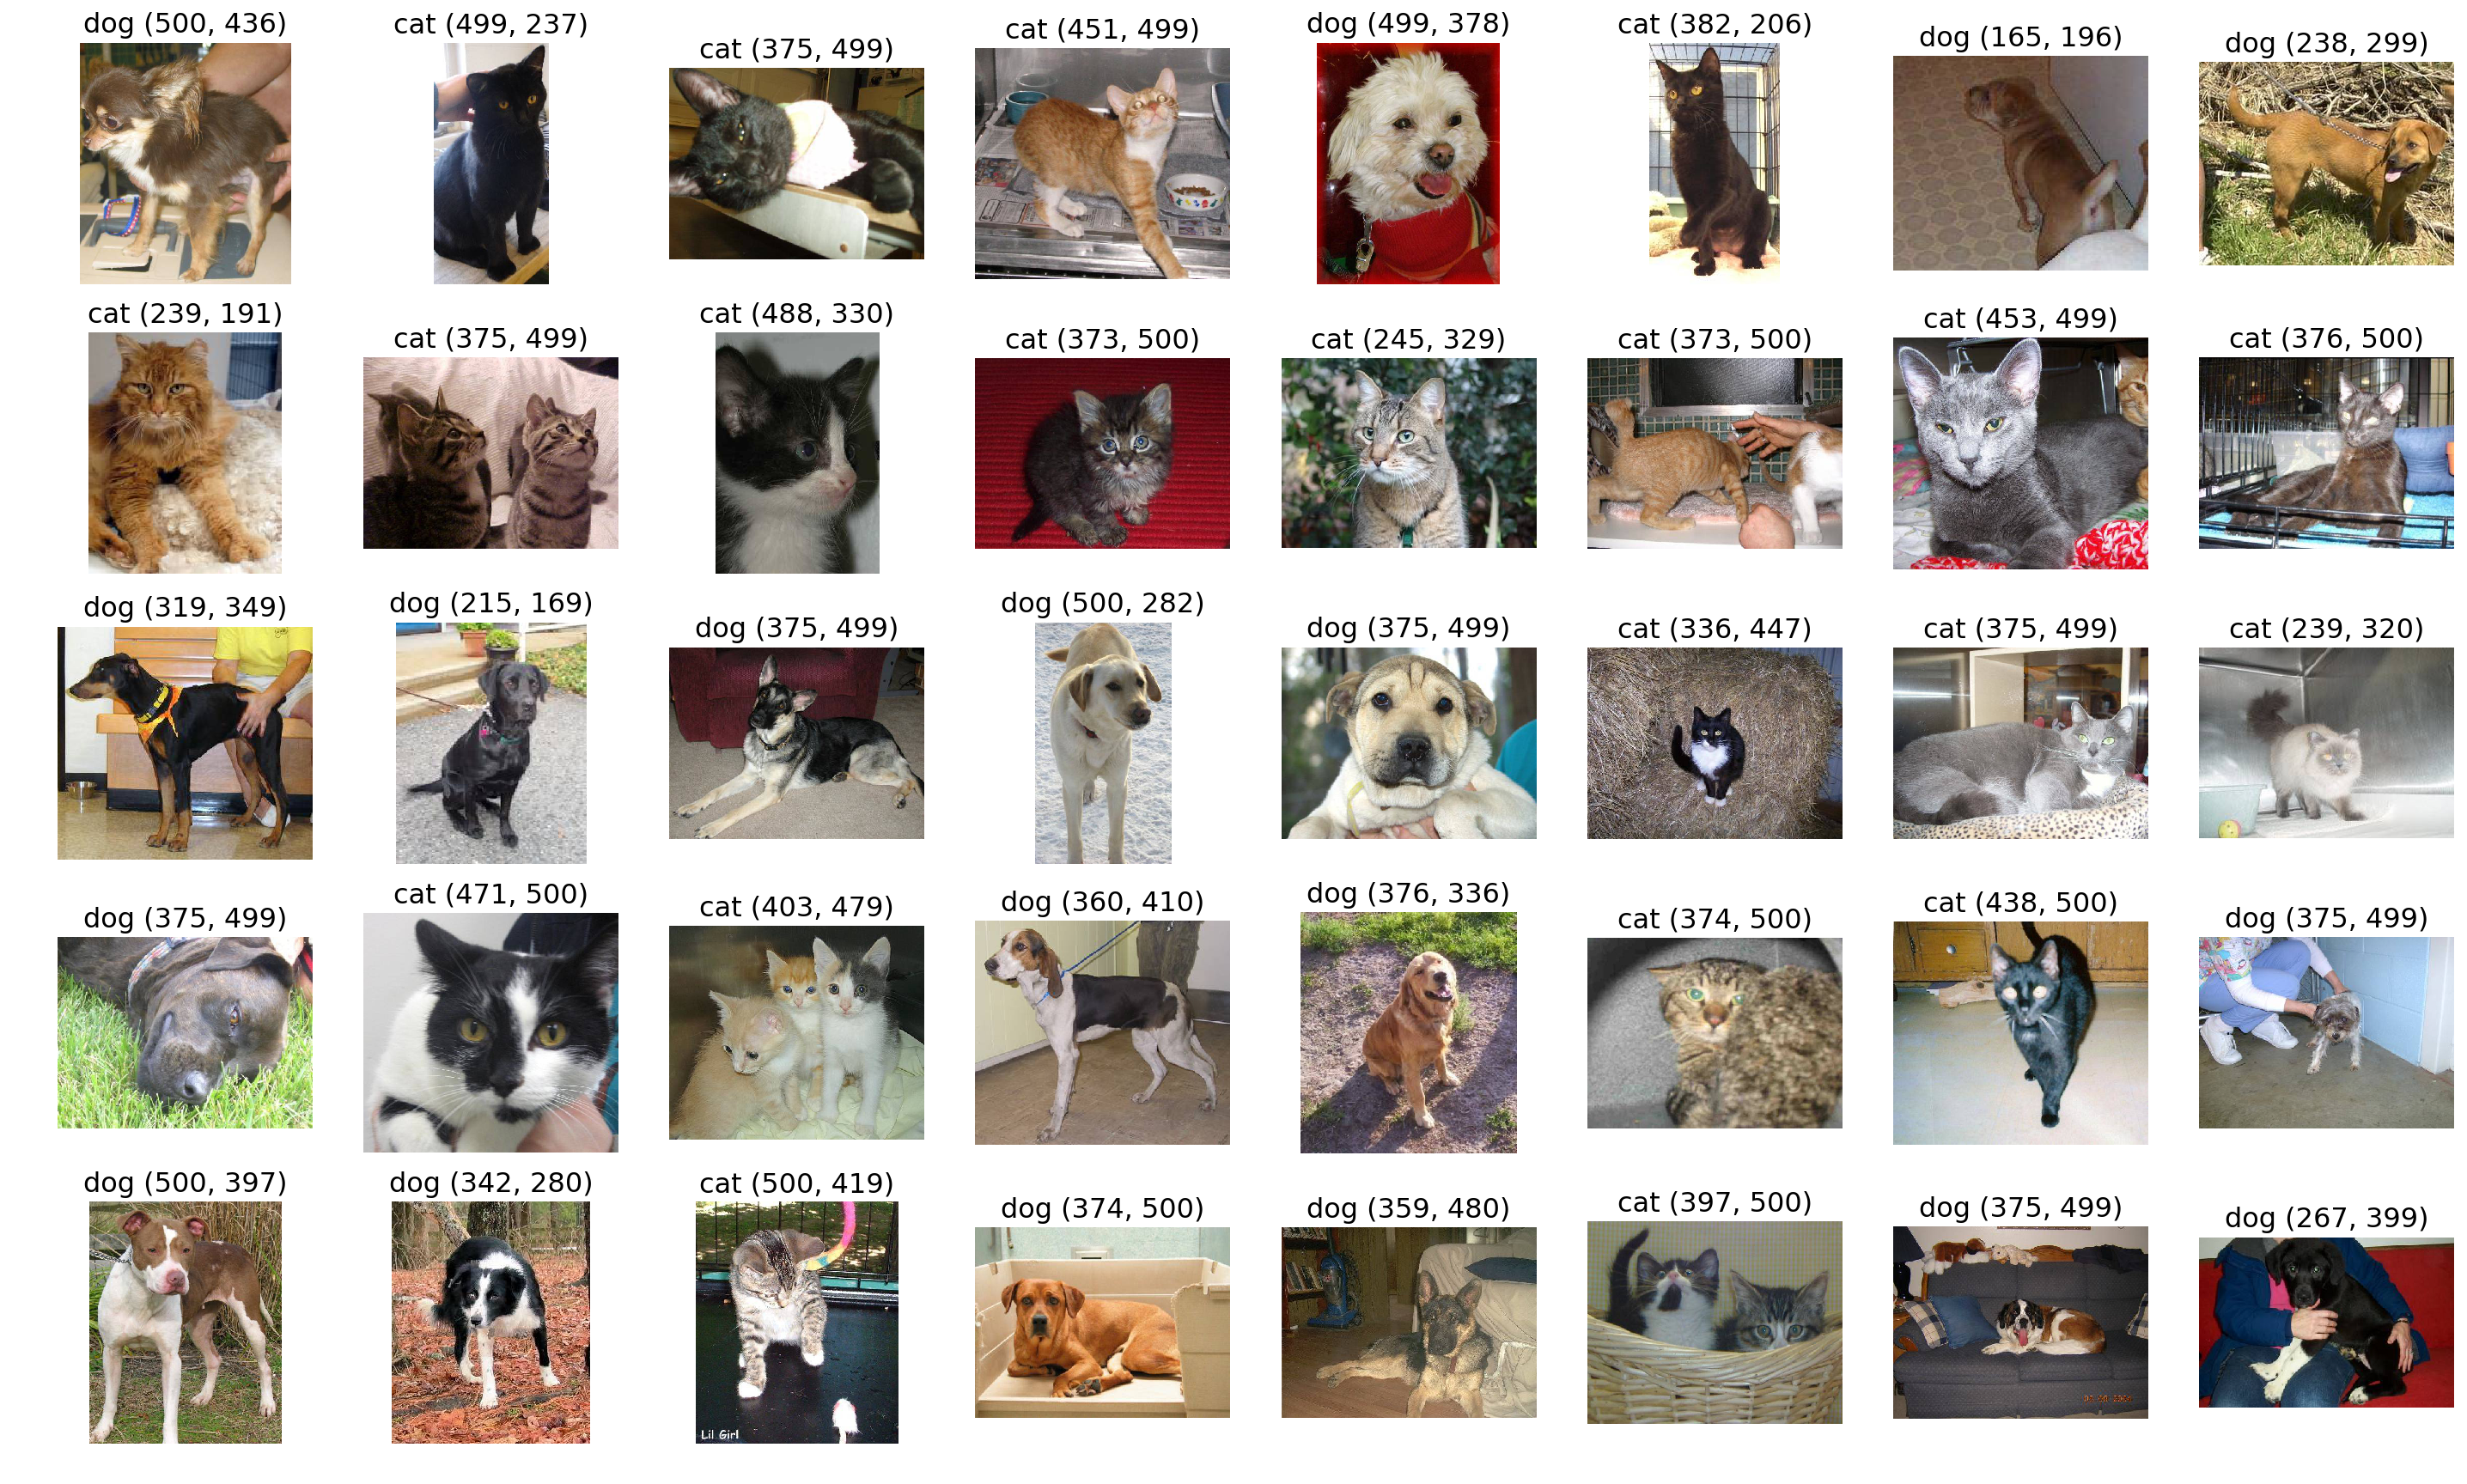

In [6]:
plt.figure(figsize=[25, 15])
random.seed(1234)
sample_size = 40
samples = random.sample(files['train'], sample_size)
labels = [x.split('.')[0] for x in samples]
for i in range(1, sample_size+1):
    plt.subplot(5, 8, i)
    tester = mpimg.imread(data_dir.format('train')+samples[i-1])
    img_shape = tester.shape[:2]
    plt.imshow(tester)
    plt.axis('off')
    plt.title(labels[i-1]+' '+str(img_shape), fontdict={'fontsize':16})
plt.savefig('samples.jpg', bbox_inches = 'tight')    
plt.show()

后面已经改过文件夹的结构，所以这段运行不出图片了。查看已保存的`samples.jpg`文件吧。

### 用预训练模型初始预测，找出那些非猫非狗的图片

先整理Imagenet1000的标签中，属于狗和猫的编号。整理工作来自优达前辈：https://zhuanlan.zhihu.com/p/34068451

In [7]:
dogs = [
     'n02085620','n02085782','n02085936','n02086079' ,'n02086240','n02086646','n02086910','n02087046'
    ,'n02087394','n02088094','n02088238','n02088364' ,'n02088466','n02088632','n02089078','n02089867'
    ,'n02089973','n02090379','n02090622','n02090721' ,'n02091032','n02091134','n02091244','n02091467'
    ,'n02091635','n02091831','n02092002','n02092339' ,'n02093256','n02093428','n02093647','n02093754'
    ,'n02093859','n02093991','n02094114','n02094258' ,'n02094433','n02095314','n02095570','n02095889'
    ,'n02096051','n02096177','n02096294','n02096437' ,'n02096585','n02097047','n02097130','n02097209'
    ,'n02097298','n02097474','n02097658','n02098105' ,'n02098286','n02098413','n02099267','n02099429'
    ,'n02099601','n02099712','n02099849','n02100236' ,'n02100583','n02100735','n02100877','n02101006'
    ,'n02101388','n02101556','n02102040','n02102177' ,'n02102318','n02102480','n02102973','n02104029'
    ,'n02104365','n02105056','n02105162','n02105251' ,'n02105412','n02105505','n02105641','n02105855'
    ,'n02106030','n02106166','n02106382','n02106550' ,'n02106662','n02107142','n02107312','n02107574'
    ,'n02107683','n02107908','n02108000','n02108089' ,'n02108422','n02108551','n02108915','n02109047'
    ,'n02109525','n02109961','n02110063','n02110185' ,'n02110341','n02110627','n02110806','n02110958'
    ,'n02111129','n02111277','n02111500','n02111889' ,'n02112018','n02112137','n02112350','n02112706'
    ,'n02113023','n02113186','n02113624','n02113712' ,'n02113799','n02113978']

cats=[
    'n02123045','n02123159','n02123394','n02123597' ,'n02124075','n02125311','n02127052']
print(len(dogs))
print(len(cats))

118
7


开始预测并判断前三是否落在猫或狗的分类内。试试用三个不同的模型来预测。

第一是ResNet50:

In [8]:
models = {'resnet50': ResNet50
         ,'inceptionv3': InceptionV3
         ,'xception': Xception}

In [9]:
name = 'resnet50'

In [10]:
model = models[name](weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
top = 60
target_size=(224, 224)
smpl = files['train'][:]

In [12]:
pred_in = []
for file in tqdm(smpl):
    true_lab = file.split('.')[0]
    img = image.load_img(data_dir.format('train')+file, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    labels = decode_predictions(preds, top)[0]
    labs = list(list(zip(*labels))[0])
    lab_check = any([((l in dogs and true_lab == 'dog') or (l in cats and true_lab == 'cat')) for l in labs])
    pred_in.append(lab_check)

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [49:28<00:00,  7.12it/s]


In [13]:
ex_idx = [x[0] for x in list(enumerate(pred_in)) if x[1] == False]
try:
    ex_files[name] = [files['train'][i] for i in ex_idx]
except NameError:
    ex_files = {name: [files['train'][i] for i in ex_idx]}
length = len(ex_files[name])
length

130

保存/读取剔除文件名单。

In [14]:
# with open('ex_files.txt', 'wb') as ef:
#     pickle.dump(ex_files, ef)
with open('ex_files.txt', 'rb') as ef:
    ex_files = pickle.load(ef)

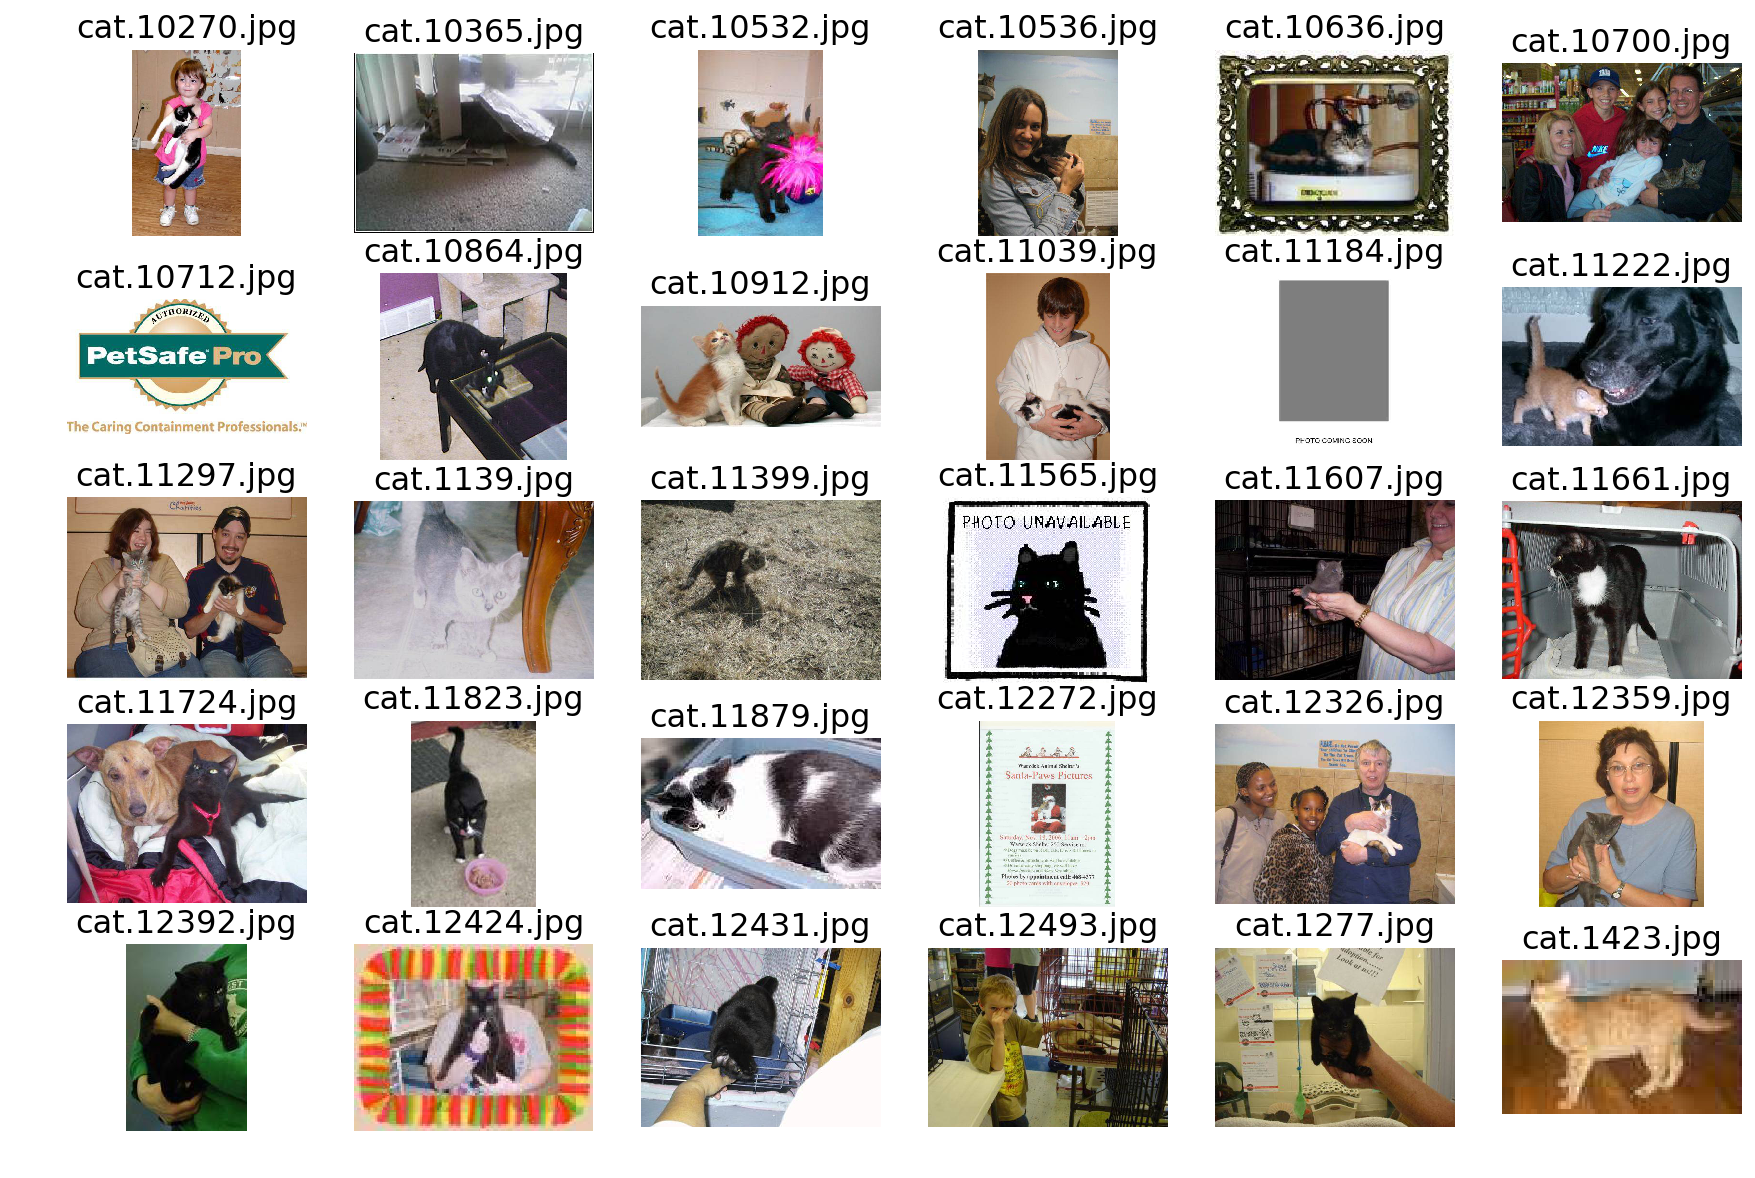

In [15]:
numeritor = 30

plt.figure(figsize=[15, int(numeritor/6*2.5)], edgecolor='gray')
for i in range(1, 1+numeritor):
    plt.subplot(int(numeritor/6)+1, 6, i)
    tester = mpimg.imread(data_dir.format('train')+ex_files[name][i-1])
    plt.imshow(tester)
    plt.axis('off')
    plt.title(ex_files[name][i-1], fontdict={'fontsize':16})
plt.savefig('ex_files_{}_top{}_sample.jpg'.format(name, top), bbox_inches = 'tight')
plt.show()

In [16]:
clean_data = [i for i in files['train'] if i not in ex_files['resnet50']]
len(clean_data)

24870

再次看下数据分布：

In [17]:
clean_labels = [x.split('.')[0] for x in clean_data]
{i: clean_labels.count(i) for i in set(clean_labels)}

{'dog': 12481, 'cat': 12389}

也还是挺均匀的。

## 整理文件夹

进一步将训练集分为训练集和验证集。

In [18]:
file_df = pd.DataFrame({'file_names': clean_data, 'labels': [x.split('.')[0] for x in clean_data]})
file_train, file_valid, label_train, label_valid = train_test_split(file_df['file_names'], file_df['labels'],
                                                                    test_size = 0.2, random_state = 0)
file_valid = file_valid.tolist()
file_train = file_train.tolist()
print(len(file_train), len(file_valid), len(label_train), len(label_valid))

19896 4974 19896 4974


创建文件件，并将验证集文件移动到`valid`文件夹中

In [19]:
try:
    os.mkdir('valid')
except FileExistsError:
    pass
if len(os.listdir('valid')) == 0:
    for i in file_valid:
        shutil.move(data_dir.format('train')+i, data_dir.format('valid'))

`train`文件夹中剩余的ex_files，移到相应的文件夹中：

In [20]:
try:
    os.mkdir('ex_files')
except FileExistsError:
    pass
if len(os.listdir('ex_files')) == 0:
    for i in ex_files['resnet50']:
        shutil.move(data_dir.format('train')+i, data_dir.format('ex_files'))

整理各分类下的文件：

In [21]:
data = {}
for i in ['train', 'valid']:
    data[i] = {j: [x for x in os.listdir(data_dir.format(i)) if x.split('.')[0] == j] for j in ['dog', 'cat']}

按照`.flow_from_directory()`的要求，将`train`和`valid`文件夹下的猫和狗分别放在各自的子文件夹下。先创建文件夹：

In [22]:
for i in ['train', 'valid']:
    try:
        for j in ['dog', 'cat']:
            os.mkdir(data_dir.format(i)+j)
    except FileExistsError:
        pass

移动文件：

In [23]:
for i in ['train', 'valid']:
    for j in ['dog', 'cat']:
        if len(os.listdir(data_dir.format(i)+j)) == 0:
            for f in data[i][j]:
                shutil.move(data_dir.format(i)+f, data_dir.format(i)+j)

至此，文件夹结构变成：
```
\Dogs_vs_Cats
    \train
        \dog
        \cat
    \valid
        \dog
        \cat
    \test
```

最后看一眼数据分布：

In [24]:
{i: {j: len(data[i][j]) for j in data[i].keys()} for i in data.keys()}

{'train': {'dog': 9975, 'cat': 9921}, 'valid': {'dog': 2506, 'cat': 2468}}

In [25]:
{i: {j: len(os.listdir(data_dir.format(i)+j)) for j in os.listdir(data_dir.format(i))} for i in ['train', 'valid']}

{'train': {'cat': 9921, 'dog': 9975}, 'valid': {'cat': 2468, 'dog': 2506}}

稳。